$V(x)=\sum_{t=1}^T R(x(t))$ \
where  $R(x)=-\|x-x_{goal}\|-variance$ \
and $T=15$

Use all datas 

# Create Environment

In [28]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[0.95,0.975,1,1.025,1.05]

global num_system
num_system=5

global last_coeff
last_coeff=1

global coeff
coeff=[1 for i in range(N+1)]

In [29]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [30]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2-obs[3]-obs[4],0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r

def value_func(funcs,flags,next_state):
    result=[]
    for i in range(6):
        if flags[i]:
            result.append(0)
        else:
            k,_=funcs[i].predict(next_state.reshape(-1,5), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.max(result)

# Learning Settings

In [31]:
global lr
lr=0.01
global eps
eps=0.2
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(funcs,flags,state,init=False):
    explo=exploration()
    if init or explo:
        return np.random.randint(6)
    else:
        result=[]
        for i in range(6):
            if flags[i]:
                return i
            else:
                k,_=funcs[i].predict(state.reshape(-1,5), return_std=True)
                result.append(k[0])
    result=np.array(result)
    return np.argmax(result)
    
def decide_u_exploitation(funcs,flags,state,init=False):
    result=[]
    for i in range(6):
        if flags[i]:
            print("Err",i)
            return i
        else:
            k,_=funcs[i].predict(state.reshape(-1,5), return_std=True)
            result.append(k[0])
    result=np.array(result)
    return np.argmax(result)

history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

history_rt=[[[] for i in range(6)] for j in range(N+1)]
history_sut=[[[] for i in range(6)] for j in range(N+1)]
flags_t=[[True for i in range(6)] for j in range(N+1)]

# Simulation


In [32]:
num_iter=100

position_result=[]
observation_result=[]
gpr_list=[[0 for i in range(6)] for j in range(N+1)]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(num_system)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0] for _ in range(num_system)])
    observation=observe(position)
    u_t=[]
    r_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(num_system)]
    
    
    history_target=[0 for i in range(6)]
    
    
    for time in range(N+1):
        if iterr<5:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation,init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_su_next[u_k] = observation_new.reshape(-1,5)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:
            #candidates_u=[]
            u_k = decide_u(gpr_list[time],flags,observation)
            #print(candidates_u)
            #u_k, explo = decide_u(observation,np.array(candidates_u))
            
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            r_t.append(r)
            
            history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
            history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
            
            
    #update
    #calculate cumulative r 
    

    '''
    for j in range(6):
        history_target[j]=last_coeff*history_r[u_t[-i]]
        gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(history_su[j], history_target[j])
    '''  
         
    #TODO
       
    for i in range(N+1):
        if i==1:
            for j in range(6):
                history_target[j]=coeff[-1]*history_r[j]
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,5), history_target[j].reshape(-1,1))
            
        elif i>1:
            for j in range(6):
                history_tar=[]
                for k in range(history_r[j].shape[0]):
                    history_tar.append(coeff[N+1-i]*history_r[j][k]+value_func(gpr_list[-i+1],flags_t[-i+1],history_su_next[j][k]))
                gpr_list[-i][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,5), np.array(history_tar).reshape(-1,1))
            '''
            r_t[-i]=0.5**(N+1-i)*r_t[-i]+value_func(gpr_list[-i+1],flags_t[-i+1],observation_t[-i+1])
            history_rt[-i][u_t[-i]].append(r_t[-i])
            history_sut[-i][u_t[-i]].append(observation_t[-i])
            gpr_list[-i][u_t[-i]]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_sut[-i][u_t[-i]]).reshape(-1,5), np.array(history_rt[-i][u_t[-i]]).reshape(-1,1))
            if flags_t[-i][u_t[-i]]:
                flags_t[-i][u_t[-i]]=False
            '''
    for j in range(6):
        history_tar=[]
        for k in range(history_r[j].shape[0]):
            history_tar.append(coeff[0]*history_r[j][k]+value_func(gpr_list[1],flags_t[1],history_su_next[j][k]))
        gpr_list[0][j]=GaussianProcessRegressor(alpha=1e-4).fit(np.array(history_su[j]).reshape(-1,5), np.array(history_tar).reshape(-1,1))

            
        
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  1%|▊                                                                                 | 1/100 [00:00<00:52,  1.89it/s]

observation = [-2.24283988 -0.06948141 -1.17809725  0.004899    0.01061629]


  2%|█▋                                                                                | 2/100 [00:01<00:55,  1.75it/s]

observation = [-1.43609269e+00 -1.68423776e+00  3.06305284e+00  7.03378975e-04
  6.62357074e-03]


  3%|██▍                                                                               | 3/100 [00:01<00:55,  1.75it/s]

observation = [-2.48243098e+00 -1.38266787e+00 -2.12057504e+00  2.39520231e-03
  9.90692500e-04]


  4%|███▎                                                                              | 4/100 [00:02<00:55,  1.73it/s]

observation = [ 2.54390160e+00 -2.30969300e+00  1.88495559e+00  1.61903091e-02
  1.30133958e-03]


  5%|████                                                                              | 5/100 [00:02<00:56,  1.68it/s]

observation = [-4.01517829e+00 -1.29804695e+00 -1.64933614e+00  7.55368451e-04
  1.34691234e-03]


  6%|████▉                                                                             | 6/100 [00:03<01:01,  1.53it/s]

observation = [-6.70955908e-01 -1.34976089e+00  7.06858347e-01  6.47132958e-05
  2.03915100e-04]


  7%|█████▋                                                                            | 7/100 [00:04<01:05,  1.42it/s]

observation = [ 6.98072189e-01 -6.29651654e-01 -1.80411242e-17  3.26832132e-03
  6.93525421e-03]


  8%|██████▌                                                                           | 8/100 [00:05<01:09,  1.32it/s]

observation = [ 1.19209537 -0.01236853  0.4712389   0.00428077  0.01645599]


  9%|███████▍                                                                          | 9/100 [00:06<01:16,  1.19it/s]

observation = [1.65615249 0.29187666 0.4712389  0.00539344 0.0213364 ]


 10%|████████                                                                         | 10/100 [00:07<01:21,  1.10it/s]

observation = [1.45735321 0.59138762 0.23561945 0.00280714 0.02697882]


 11%|████████▉                                                                        | 11/100 [00:08<01:26,  1.03it/s]

observation = [2.28780729e+00 6.22015530e-01 4.16333634e-18 9.29521216e-03
 3.00280968e-02]


 12%|█████████▋                                                                       | 12/100 [00:09<01:32,  1.05s/it]

observation = [ 2.38133778  0.85932702 -0.23561945  0.00989187  0.03982016]


 13%|██████████▌                                                                      | 13/100 [00:11<01:38,  1.13s/it]

observation = [1.90386050e+00 1.64337234e+00 4.71238898e-01 5.56759861e-04
 4.65271236e-02]


 14%|███████████▎                                                                     | 14/100 [00:12<01:41,  1.18s/it]

observation = [2.37778914 0.34416386 1.17809725 0.011136   0.02407818]


 15%|████████████▏                                                                    | 15/100 [00:13<01:48,  1.27s/it]

observation = [1.51957124e+00 1.99518044e+00 7.06858347e-01 1.71534024e-04
 5.17623958e-02]


 16%|████████████▉                                                                    | 16/100 [00:15<01:53,  1.35s/it]

observation = [2.51931178 1.37610074 0.9424778  0.00645105 0.04803283]


 17%|█████████████▊                                                                   | 17/100 [00:17<01:59,  1.44s/it]

observation = [2.42785563e+00 2.06460126e+00 9.42477796e-01 1.28231059e-03
 6.07384069e-02]


 18%|██████████████▌                                                                  | 18/100 [00:18<02:06,  1.55s/it]

observation = [1.54244820e+00 4.89421964e-01 4.16333634e-18 3.83660293e-03
 2.48309652e-02]


 19%|███████████████▍                                                                 | 19/100 [00:20<02:13,  1.65s/it]

observation = [2.73701989e+00 1.72613671e+00 4.71238898e-01 1.13237615e-03
 4.24125318e-02]


 20%|████████████████▏                                                                | 20/100 [00:22<02:18,  1.73s/it]

observation = [1.60717668e+00 1.34982399e+00 4.71238898e-01 9.04022899e-04
 4.24187405e-02]


 21%|█████████████████                                                                | 21/100 [00:24<02:23,  1.82s/it]

observation = [2.61248185 1.84215429 0.70685835 0.00277458 0.0561389 ]


 22%|█████████████████▊                                                               | 22/100 [00:26<02:28,  1.90s/it]

observation = [ 2.42114467e+00  2.07441839e+00 -1.80411242e-17  1.13568987e-03
  6.18634160e-02]


 23%|██████████████████▋                                                              | 23/100 [00:29<02:37,  2.05s/it]

observation = [1.36134392e+00 2.12680140e+00 9.42477796e-01 6.96435987e-04
 5.30818628e-02]


 24%|███████████████████▍                                                             | 24/100 [00:31<02:44,  2.17s/it]

observation = [ 3.21132735  1.61010365 -0.23561945  0.00541832  0.04936815]


 25%|████████████████████▎                                                            | 25/100 [00:34<02:51,  2.29s/it]

observation = [ 3.08364475  1.42857356 -0.4712389   0.00969202  0.04896041]


 26%|█████████████████████                                                            | 26/100 [00:36<02:57,  2.39s/it]

observation = [1.70074638e+00 2.73709302e+00 9.42477796e-01 1.08220274e-03
 7.27779158e-02]


 27%|█████████████████████▊                                                           | 27/100 [00:39<03:02,  2.50s/it]

observation = [ 3.33006144e+00  1.89069954e+00 -4.85722573e-17  7.08237306e-03
  6.10022925e-02]


 28%|██████████████████████▋                                                          | 28/100 [00:42<03:10,  2.64s/it]

observation = [2.57123889e+00 2.07477857e+00 9.42477796e-01 2.32461462e-03
 6.42844960e-02]


 29%|███████████████████████▍                                                         | 29/100 [00:45<03:17,  2.79s/it]

observation = [ 2.81682826  2.16220022 -1.17809725  0.01225389  0.07153567]


 30%|████████████████████████▎                                                        | 30/100 [00:48<03:25,  2.93s/it]

observation = [2.61017815e+00 2.08470247e+00 7.06858347e-01 2.60336565e-03
 6.59253135e-02]


 31%|█████████████████████████                                                        | 31/100 [00:52<03:35,  3.13s/it]

observation = [ 3.02703364e+00  1.93908700e+00 -1.80411242e-17  6.94116487e-04
  4.52042634e-02]


 32%|█████████████████████████▉                                                       | 32/100 [00:56<03:50,  3.38s/it]

observation = [2.78372664 1.89608789 0.4712389  0.00462841 0.06153266]


 33%|██████████████████████████▋                                                      | 33/100 [01:00<04:03,  3.63s/it]

observation = [ 2.74677476  2.14797973 -0.4712389   0.00413408  0.07031839]


 34%|███████████████████████████▌                                                     | 34/100 [01:05<04:15,  3.86s/it]

observation = [ 2.81345567  2.0486276  -0.70685835  0.00508066  0.06675541]


 35%|████████████████████████████▎                                                    | 35/100 [01:09<04:29,  4.14s/it]

observation = [ 3.14083675  1.74336005 -0.70685835  0.00445481  0.05270014]


 36%|█████████████████████████████▏                                                   | 36/100 [01:14<04:36,  4.32s/it]

observation = [2.68728461 1.99807339 0.70685835 0.00345339 0.06373717]


 37%|█████████████████████████████▉                                                   | 37/100 [01:19<04:46,  4.55s/it]

observation = [3.18634589 2.44111064 0.70685835 0.00458205 0.08114718]


 38%|██████████████████████████████▊                                                  | 38/100 [01:25<04:55,  4.77s/it]

observation = [2.68467287 2.02023977 0.70685835 0.00338167 0.06475168]


 39%|███████████████████████████████▌                                                 | 39/100 [01:29<04:51,  4.78s/it]

observation = [ 3.66264744  2.41353916 -0.23561945  0.00624085  0.07677332]


 40%|████████████████████████████████▍                                                | 40/100 [01:33<04:30,  4.51s/it]

observation = [2.63629914 2.00972854 0.70685835 0.00292544 0.06314689]


 41%|█████████████████████████████████▏                                               | 41/100 [01:37<04:17,  4.36s/it]

observation = [2.68078976 2.14253318 0.23561945 0.00311957 0.07043261]


 42%|██████████████████████████████████                                               | 42/100 [01:41<04:09,  4.31s/it]

observation = [ 3.18938829e+00  2.21569776e+00 -1.80411242e-17  4.88651895e-03
  7.07439481e-02]


 43%|██████████████████████████████████▊                                              | 43/100 [01:46<04:07,  4.34s/it]

observation = [ 3.14717957e+00  2.17310135e+00 -1.52655666e-17  4.45273950e-03
  6.77983764e-02]


 44%|███████████████████████████████████▋                                             | 44/100 [01:50<04:06,  4.40s/it]

observation = [ 3.28204332  2.39652016 -0.23561945  0.0062055   0.07899514]


 45%|████████████████████████████████████▍                                            | 45/100 [01:55<04:08,  4.52s/it]

observation = [2.77004622 1.88435722 0.70685835 0.00449609 0.0606662 ]


 46%|█████████████████████████████████████▎                                           | 46/100 [02:00<04:10,  4.64s/it]

observation = [2.67441191 2.03846052 0.70685835 0.00326207 0.06530304]


 47%|██████████████████████████████████████                                           | 47/100 [02:05<04:15,  4.82s/it]

observation = [3.08957238 2.34343941 0.4712389  0.00365936 0.07389555]


 48%|██████████████████████████████████████▉                                          | 48/100 [02:11<04:24,  5.08s/it]

observation = [2.81606332 1.18573994 0.23561945 0.00554298 0.03746466]


 49%|███████████████████████████████████████▋                                         | 49/100 [02:18<04:42,  5.53s/it]

observation = [ 3.16018412  2.37082003 -0.23561945  0.00466118  0.07379428]


 50%|████████████████████████████████████████▌                                        | 50/100 [02:24<04:42,  5.65s/it]

observation = [2.61216503e+00 2.02704624e+00 1.17809725e+00 2.59524401e-03
 6.40073312e-02]


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:30<04:42,  5.77s/it]

observation = [2.62071839 2.03395487 0.9424778  0.00277471 0.06378657]


 52%|██████████████████████████████████████████                                       | 52/100 [02:36<04:42,  5.88s/it]

observation = [2.66761232 2.02449021 0.4712389  0.00318948 0.06469178]


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:42<04:43,  6.03s/it]

observation = [2.60024619e+00 2.11335446e+00 4.71238898e-01 2.47761574e-03
 6.70673134e-02]


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:49<04:44,  6.19s/it]

observation = [2.75251561 1.96569359 0.9424778  0.00420694 0.06371396]


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:56<04:48,  6.42s/it]

observation = [ 3.2318658   1.95726803 -0.23561945  0.00546431  0.06229664]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:03<04:50,  6.59s/it]

observation = [2.64008384 2.06174259 0.23561945 0.00293864 0.06530897]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:10<04:55,  6.87s/it]

observation = [ 3.26814316  2.00144878 -0.70685835  0.00592909  0.0644129 ]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:18<04:57,  7.10s/it]

observation = [2.72385082 2.04466092 0.9424778  0.00371929 0.06692307]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:26<05:00,  7.33s/it]

observation = [2.64833463 2.03464908 0.4712389  0.0030214  0.06449032]


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:34<05:02,  7.57s/it]

observation = [2.71071235 1.9681172  0.23561945 0.00370897 0.06305952]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:42<05:06,  7.87s/it]

observation = [2.69981316 2.00736346 0.23561945 0.00358424 0.06437195]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:53<05:25,  8.58s/it]

observation = [2.78210411 2.4095827  0.23561945 0.00459576 0.07710233]


 63%|███████████████████████████████████████████████████                              | 63/100 [04:02<05:32,  8.98s/it]

observation = [ 3.21411327  2.16424899 -0.4712389   0.00519074  0.06973505]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [04:12<05:31,  9.21s/it]

observation = [2.80203801 2.00185888 0.4712389  0.00478261 0.06617359]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [04:23<05:38,  9.68s/it]

observation = [2.86348262 1.80496249 0.4712389  0.00577239 0.05933509]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [04:33<05:36,  9.88s/it]

observation = [ 3.34797395  2.07219325 -0.70685835  0.00729463  0.06501483]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:44<05:29, 10.00s/it]

observation = [2.69355790e+00 2.05015000e+00 4.16333634e-18 3.47935261e-03
 6.60048817e-02]


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:54<05:25, 10.18s/it]

observation = [2.7647507  1.9423548  0.9424778  0.00436141 0.06304604]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [05:05<05:22, 10.42s/it]

observation = [2.57076504e+00 2.09804361e+00 9.42477796e-01 2.26127441e-03
 6.55905220e-02]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [05:16<05:19, 10.67s/it]

observation = [3.14625405 2.2694028  0.23561945 0.00436893 0.07185266]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [05:28<05:17, 10.95s/it]

observation = [3.17658749e+00 2.26600553e+00 4.16333634e-18 4.68878928e-03
 7.26600148e-02]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [05:40<05:14, 11.23s/it]

observation = [3.13684452 2.19701891 0.9424778  0.00439046 0.06811148]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [05:52<05:11, 11.55s/it]

observation = [2.78354764 1.85387339 0.9424778  0.00465062 0.05984952]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [06:06<05:15, 12.14s/it]

observation = [2.82605643 1.78165947 0.70685835 0.00520212 0.05809774]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [06:20<05:21, 12.87s/it]

observation = [ 2.67743601e+00  1.98305522e+00 -1.80411242e-17  3.33879966e-03
  6.30472024e-02]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [06:36<05:27, 13.65s/it]

observation = [2.98592363 1.62269347 0.4712389  0.00776261 0.05458872]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [06:51<05:23, 14.05s/it]

observation = [3.30918382 2.25848839 0.4712389  0.00660913 0.07465704]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [07:07<05:25, 14.78s/it]

observation = [ 2.82306247  2.16107842 -0.9424778   0.00509472  0.07199247]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [07:24<05:19, 15.22s/it]

observation = [2.82920335 1.86101454 0.4712389  0.00523865 0.061     ]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [07:40<05:14, 15.71s/it]

observation = [2.72485753 1.9687453  0.70685835 0.003876   0.06334591]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [07:58<05:08, 16.25s/it]

observation = [ 2.94233066e+00  2.19167170e+00 -2.63677968e-17  2.26199723e-03
  6.48431400e-02]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [08:16<05:01, 16.75s/it]

observation = [3.14880994 2.30072052 0.4712389  0.00438011 0.07326351]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [08:35<04:54, 17.34s/it]

observation = [2.78342481e+00 2.59074478e+00 1.64933614e+00 1.10015221e-03
 7.73995135e-02]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [08:54<04:46, 17.93s/it]

observation = [2.79889301 1.9288655  0.70685835 0.00475072 0.06334857]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [09:14<04:41, 18.74s/it]

observation = [2.86797525 1.79710697 0.9424778  0.00581003 0.05924255]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [09:35<04:30, 19.35s/it]

observation = [2.75023312 1.93225851 0.9424778  0.00419073 0.06236013]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [09:57<04:21, 20.13s/it]

observation = [3.14964118 2.20881281 0.4712389  0.00448431 0.06912451]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [10:22<04:18, 21.58s/it]

observation = [2.81525985 1.89527584 0.4712389  0.00502494 0.06215907]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [10:45<04:03, 22.09s/it]

observation = [2.79317211 1.92501066 0.9424778  0.00470312 0.06300001]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [11:09<03:46, 22.65s/it]

observation = [2.52253600e+00 2.14444879e+00 9.42477796e-01 1.84881575e-03
 6.64527148e-02]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [11:34<03:28, 23.12s/it]

observation = [ 3.17218220e+00  2.14812182e+00 -1.80411242e-17  4.73234896e-03
  6.74174334e-02]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [11:59<03:09, 23.75s/it]

observation = [3.08922426 2.21038951 0.23561945 0.00363795 0.06903725]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [12:23<02:47, 23.91s/it]

observation = [2.58420818e+00 2.12952438e+00 2.35619449e-01 2.38066819e-03
 6.69466239e-02]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [12:45<02:20, 23.43s/it]

observation = [2.75132665 1.85295651 0.4712389  0.0042009  0.0595301 ]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [13:08<01:55, 23.18s/it]

observation = [2.74176897 1.98490366 0.23561945 0.00404384 0.06442792]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [13:31<01:32, 23.09s/it]

observation = [2.2887223  1.45022725 0.4712389  0.00340757 0.0469798 ]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [13:55<01:09, 23.27s/it]

observation = [2.78155336 1.85340592 0.9424778  0.00459168 0.06002941]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [14:19<00:47, 23.52s/it]

observation = [2.81873053 1.83269817 0.70685835 0.00508721 0.05990057]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [14:43<00:23, 23.85s/it]

observation = [2.74856162 1.90601044 0.9424778  0.00422696 0.061099  ]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:09<00:00,  9.09s/it]

observation = [3.19727862 2.21348431 0.4712389  0.00511162 0.07020997]


# Results

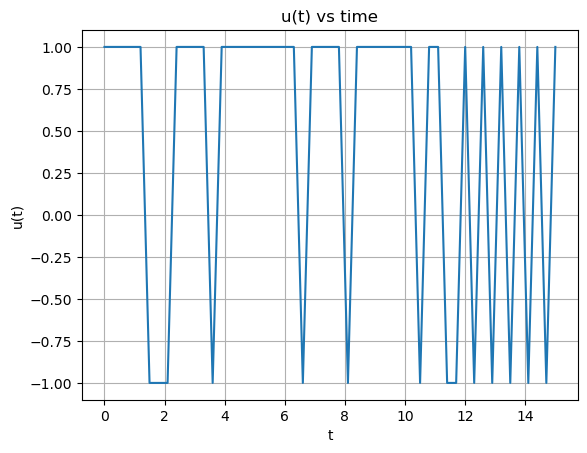

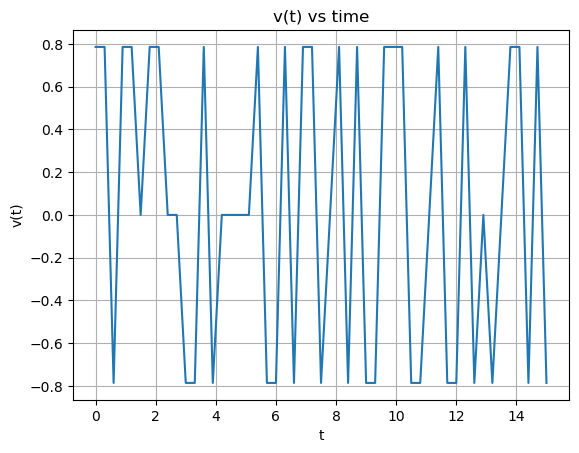

In [33]:
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


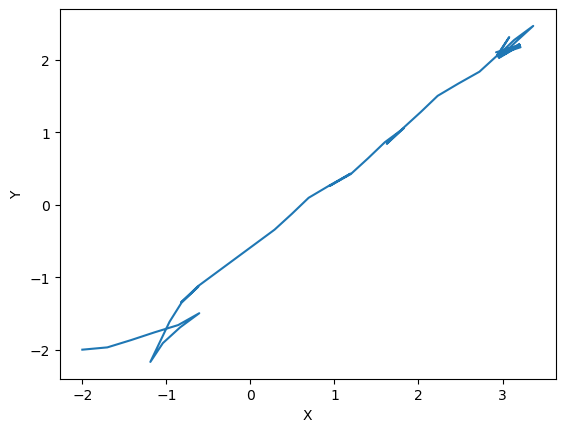

In [34]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

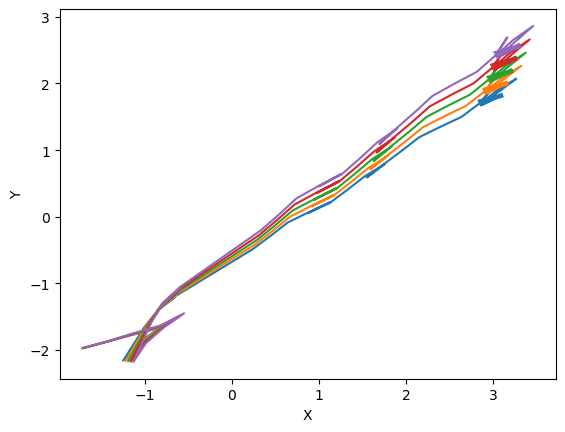

1.757991232218667


In [35]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))


## Best Trajectory

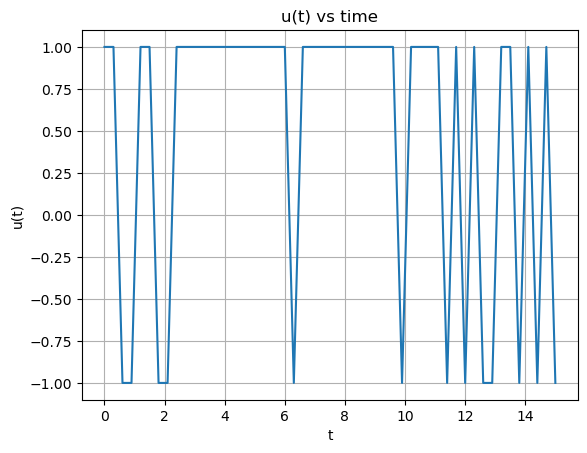

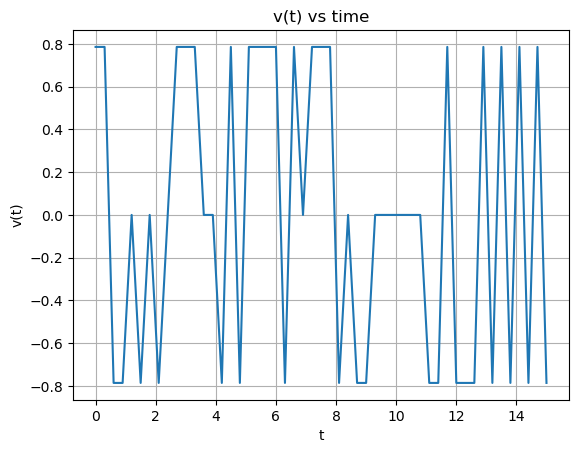

In [36]:
u=[2*(0.5-i%2) for i in best_u]
v=[(1-i//2)*np.pi/4 for i in best_u]

x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

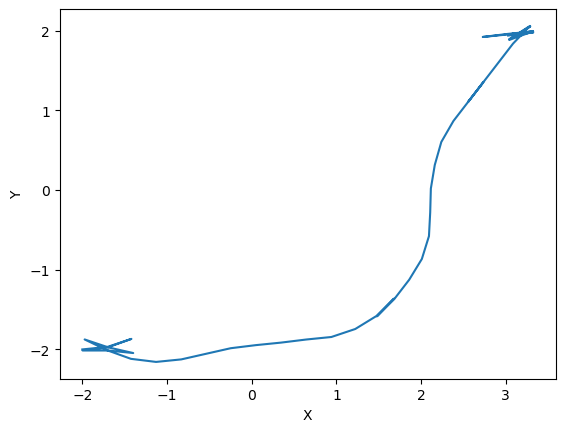

In [37]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

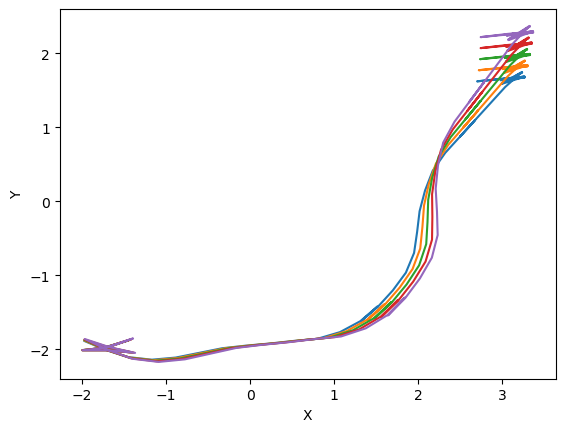

0.9909569950743913


In [38]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(np.array(pos)))

## Pure Exploitation Trajectory

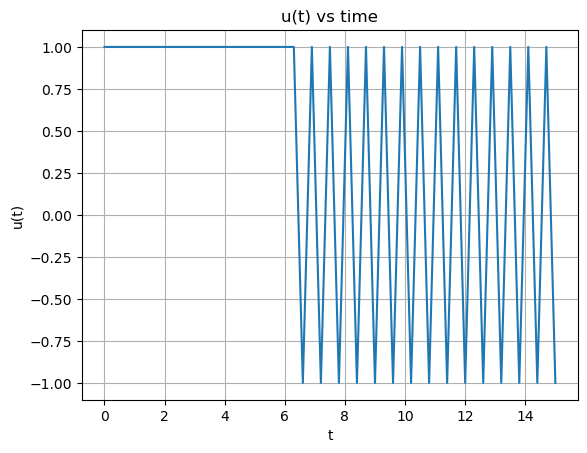

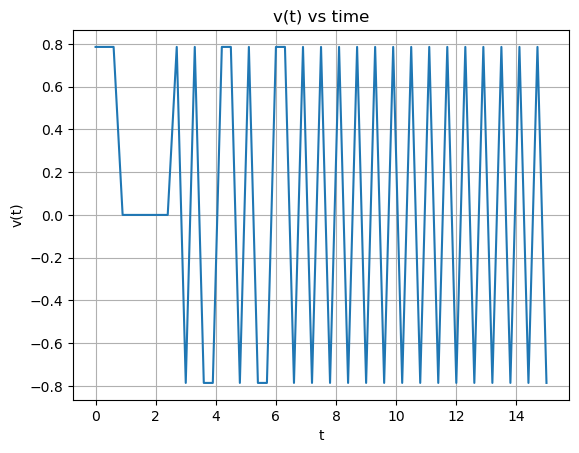

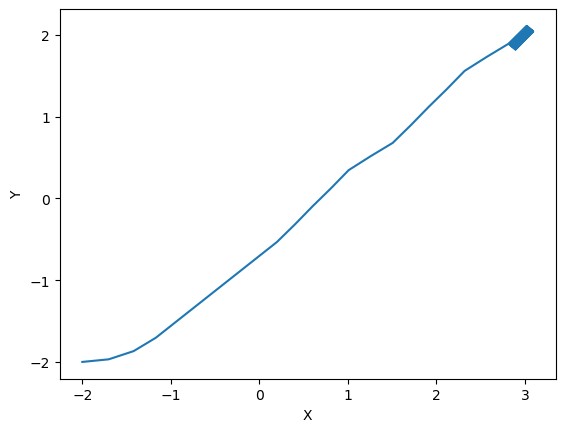

In [39]:
position=np.array([[-2,-2,0] for _ in range(num_system)])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(num_system)]

for time in range(N+1):           
    
    #print(candidates_u)
    u_k = decide_u_exploitation(gpr_list[time],flags,observation)
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    '''
    
u=[2*(0.5-i%2) for i in u_t]
v=[(1-i//2)*np.pi/4 for i in u_t]


x = np.linspace(0, T, N+1)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, N+1)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

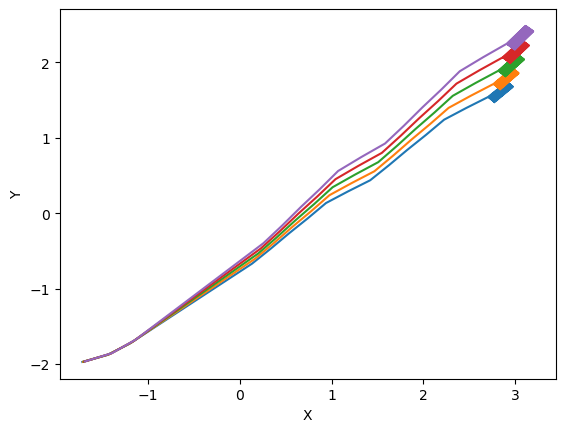

1.393115263742609


In [40]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
print(reward_raw(position))